### OpenCV DNN 패키지를 이용하여 Faster R-CNN 기반의 Object Detection 수행

In [1]:
!pwd

/content


In [2]:
!mkdir ./data

In [3]:
!wget -O ./data/test_00.jpg https://github.com/hs0224/a-professor-student-research-club/blob/hs0224/hs0224/images/test_00.jpg?raw=true

--2022-12-04 04:51:59--  https://github.com/hs0224/a-professor-student-research-club/blob/hs0224/hs0224/images/test_00.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/hs0224/a-professor-student-research-club/raw/hs0224/hs0224/images/test_00.jpg [following]
--2022-12-04 04:51:59--  https://github.com/hs0224/a-professor-student-research-club/raw/hs0224/hs0224/images/test_00.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hs0224/a-professor-student-research-club/hs0224/hs0224/images/test_00.jpg [following]
--2022-12-04 04:51:59--  https://raw.githubusercontent.com/hs0224/a-professor-student-research-club/hs0224/hs0224/images/test_00.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.1

image shape: (600, 1000, 3)


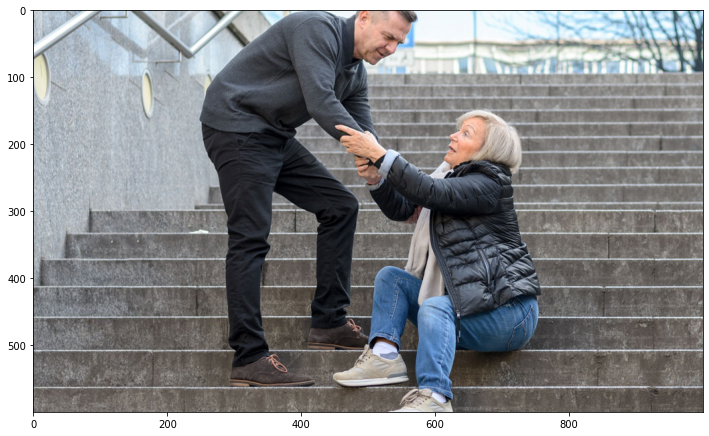

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

img = cv2.imread('./data/test_00.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print('image shape:', img.shape)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)

In [5]:
!mkdir ./pretrained
!wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt

--2022-12-04 04:55:04--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.124.128, 2607:f8b0:4001:c14::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.124.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M   153MB/s    in 2.4s    

2022-12-04 04:55:07 (153 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2022-12-04 04:55:07--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.git

In [6]:
!tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained 

faster_rcnn_resnet50_coco_2018_01_28/
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.index
faster_rcnn_resnet50_coco_2018_01_28/checkpoint
faster_rcnn_resnet50_coco_2018_01_28/pipeline.config
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.data-00000-of-00001
faster_rcnn_resnet50_coco_2018_01_28/model.ckpt.meta
faster_rcnn_resnet50_coco_2018_01_28/saved_model/
faster_rcnn_resnet50_coco_2018_01_28/saved_model/saved_model.pb
faster_rcnn_resnet50_coco_2018_01_28/saved_model/variables/
faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb


In [7]:
!pwd
!ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28

/content
total 296080
6815752 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 .
6815749 drwxr-xr-x 3 root   root      4096 Dec  4 04:55 ..
6815754 -rw-r--r-- 1 345018 5000        77 Feb  1  2018 checkpoint
6815761 -rw-r--r-- 1 345018 5000 120549957 Feb  1  2018 frozen_inference_graph.pb
6815756 -rw-r--r-- 1 345018 5000 176914228 Feb  1  2018 model.ckpt.data-00000-of-00001
6815753 -rw-r--r-- 1 345018 5000     14460 Feb  1  2018 model.ckpt.index
6815757 -rw-r--r-- 1 345018 5000   5675175 Feb  1  2018 model.ckpt.meta
6815755 -rw-r--r-- 1 345018 5000      3240 Feb  1  2018 pipeline.config
6815758 drwxr-xr-x 3 345018 5000      4096 Feb  1  2018 saved_model


#### dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩

In [8]:
cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 
                                     './pretrained/config_graph.pbtxt')

#### coco 데이터 세트의 클래스 id별 클래스명 지정

In [9]:
# OpenCV Tensorflow Faster-RCNN용
labels_to_names_0 = {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

#### 이미지를 preprocessing 수행하여 Network에 입력하고 Object Detection 수행 후 결과를 이미지에 시각화

In [10]:
img.shape

(600, 1000, 3)

person: 1.0000
person: 0.9945
person: 0.9645


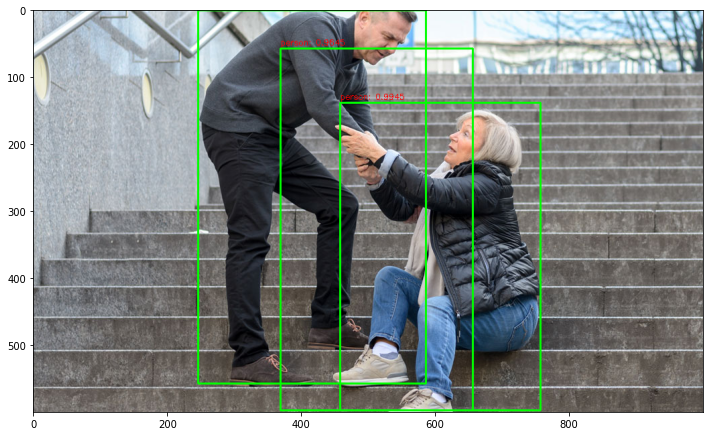

In [13]:
# 원본 이미지가 Faster RCNN기반 네트웍으로 입력 시 resize됨
# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 왼본 이미지 shape정보가 필요
rows = img.shape[0]
cols = img.shape[1]

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접! 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
# Bouding box를 그릴 이미지를 별도로 생성
draw_img = img.copy()

# 입력 이미지를 Preprocessing 하여 네트웍에 입력
cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

# Inference 네트웍에서 Output 추출(Object Detection 수행하여 결과를 cvOut으로 반환)
# cv_out : Detected 정보가 들어있음
cv_out= cv_net.forward()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# Detected Object들을 iteration 하면서 정보 추출
for detection in cv_out[0,0,:,:]:
  prob = float(detection[2])
  class_id = int(detection[1])
  # Detected된 Object들의 prob가 0.5 이상만 추출(filtering out)
  if prob > 0.5:
    # Detected된 Object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    left = detection[3] * cols      # xmin
    top = detection[4] * rows       # ymin
    right = detection[5] * cols     # xmax
    bottom = detection[6] * rows    # ymax

    caption = f"{labels_to_names_0[class_id]}: {prob:.4f}"
    print(caption)

    # Bounding Box를 draw_img에 그림(위치 인자는 반드시 정수형)
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)


img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)


```
ex)
[0.00000000e+00, 0.00000000e+00, 9.99780715e-01,
          2.80248284e-01, 4.11070347e-01, 4.66062069e-01,
          8.59829903e-01]

1번째 : 클래스 id 0번
2번쨰 : 클래스 id 0번으로 99% 확신 
3번째 : xmin 0.28
4번쨰 : ymin 0.41
5번째 : xmax 0.46
6번째 : ymax 0.85

-> 0~1사의 값으로 스케일링 된 값
좌표값으로 바꿔줄려면 다시 원본 사이즈의 width, height를 곱해줘야 원래의 좌표값이 나옴
이런게 100개의 정보가 존재
```




In [18]:
cv_out.shape # detected object가 100개 있음

(1, 1, 100, 7)

In [19]:
print(cv_out[0,0,0,:])

[0.         0.         0.9999509  0.24612156 0.         0.58621097
 0.9296963 ]
